## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
np.random.seed(42)

# Load processed data
df = pd.read_parquet('processed_train_uci.parquet')
print('Loaded processed data shape:', df.shape)

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Helper: pick a single "store" (country) for per-series examples
stores = df['Store'].unique().tolist()
print('Found stores (countries):', stores[:8], '...')

# Choose a store with enough data; prefer United Kingdom if present
preferred = 'United Kingdom'
if preferred in stores:
    store_sel = preferred
else:
    store_sel = stores[0]

print('Using store for single-series demos:', store_sel)

# Prepare a single series for that store
store_df = df[df['Store'] == store_sel].sort_values('Date')
series = store_df.set_index('Date')['Sales'].asfreq('D')
# Fill missing dates with 0 (ecommerce may not have zeros but keep consistent)
series = series.fillna(0)

Loaded processed data shape: (1554, 35)
Found stores (countries): ['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada', 'Channel Islands', 'Cyprus'] ...
Using store for single-series demos: United Kingdom


## sktime Reduction Recipe


Running sktime reduction demo...
sktime MAPE for United Kingdom: 43.99%


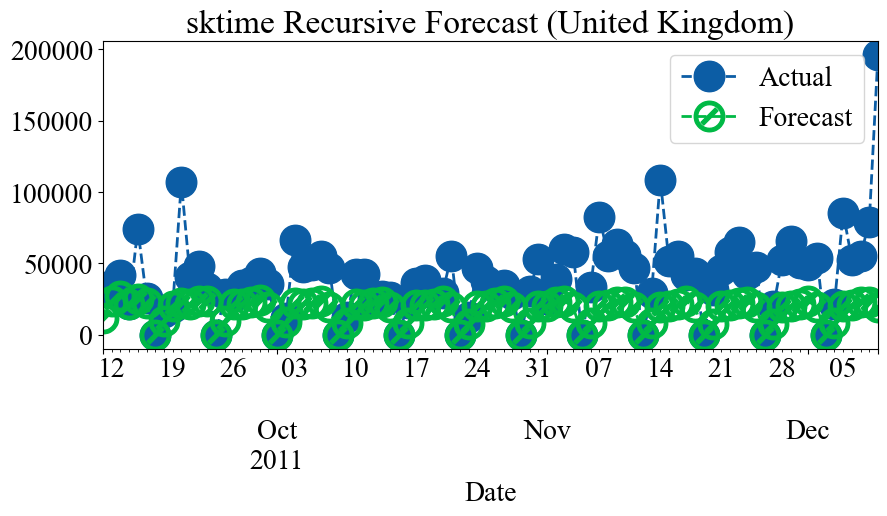

In [2]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

print('\nRunning sktime reduction demo...')
# Train/test split last 90 days (or smaller if series shorter)
test_horizon = min(90, len(series) // 4)
if test_horizon < 7:
    test_horizon = min(14, len(series) // 4)

y_train, y_test = temporal_train_test_split(series, test_size=test_horizon)
fh = np.arange(1, len(y_test)+1)

regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
forecaster = make_reduction(regressor, window_length=21, strategy='recursive')

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'sktime MAPE for {store_sel}: {mape:.2%}')

# Plot
plt.figure(figsize=(10, 4))
y_test.plot(label='Actual')
y_pred.plot(label='Forecast')
plt.legend()
plt.title(f'sktime Recursive Forecast ({store_sel})')
plt.show()

## mlforecast (multi-series lag automation)

In [ ]:
from xgboost import XGBRegressor
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean

print('\nRunning mlforecast demo...')
# Select up to 5 stores with most data
top_stores = df['Store'].value_counts().nlargest(5).index.tolist()
sample = df[df['Store'].isin(top_stores)].copy()
sample_df = sample[['Store', 'Date', 'Sales']].rename(columns={'Store': 'unique_id', 'Date': 'ds', 'Sales': 'y'})
sample_df = sample_df.sort_values(['unique_id', 'ds'])


fcst = MLForecast(
models=[XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')],
freq='D',
lags=[1, 7],
lag_transforms={7: [RollingMean(window_size=14)]},
date_features=['dayofweek', 'month']
)


fcst.fit(sample_df)
preds = fcst.predict(14)
print('mlforecast predictions head:')
print(preds.head())

## tsfresh static features

In [6]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters

print('\nRunning tsfresh demo...')
# Build per-store short time series for top 4 stores
small = df[df['Store'].isin(top_stores)].copy()
# Keep a consistent window (e.g., last 120 days per store) if available
extracted = []
for s in top_stores:
    sdata = small[small['Store'] == s].sort_values('Date').tail(120)
    if len(sdata) < 20:
        continue
    tmp = pd.DataFrame({'id': s, 'time': sdata['Date'].dt.strftime('%Y-%m-%d'), 'value': sdata['Sales'].values})
    extracted.append(tmp)

if len(extracted) > 0:
    df_tsfresh = pd.concat(extracted)
    static_features = extract_features(df_tsfresh, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())
    static_features.reset_index(inplace=True)
    static_features.rename(columns={'index': 'unique_id'}, inplace=True)
    cols_show = [c for c in static_features.columns if 'value__mean' in c or 'value__standard_deviation' in c or 'autocorrelation' in c][:5]
    print('Sample tsfresh features:')
    print(static_features.head()[cols_show])
else:
    print('Not enough data for tsfresh demo.')


Running tsfresh demo...


Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


Sample tsfresh features:
   value__mean_abs_change  value__mean_change  \
0              376.953415           -1.676341   
1             1878.564790           -2.714706   
2              986.696555           -8.666975   
3              988.071008            8.176387   
4            17719.127462         1493.002773   

   value__mean_second_derivative_central   value__mean  \
0                              -5.982654    496.341446   
1                             -16.159661   1808.918833   
2                               3.109619   1157.349417   
3                               2.692881   1133.742500   
4                             466.453136  37900.435192   

   value__standard_deviation  
0                 344.131576  
1                2162.274477  
2                1320.601700  
3                1024.890511  
4               24171.128891  


## Classical decomposition (statsmodels)


Running classical decomposition...


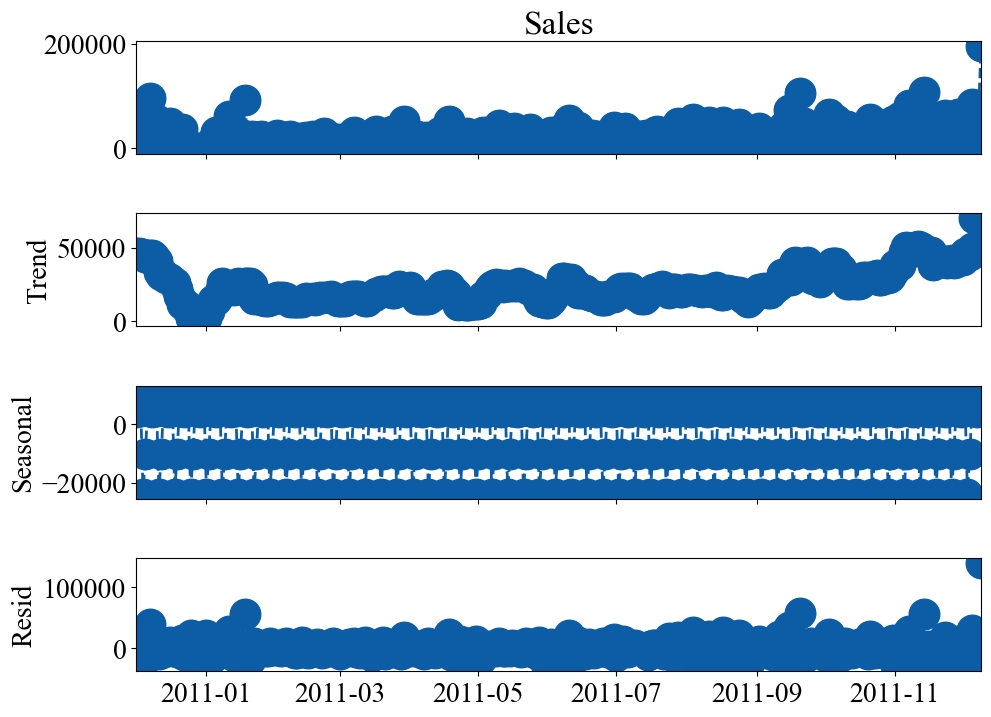

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

print('\nRunning classical decomposition...')
# Ensure we have enough points and weekly seasonality
if len(series) >= 28:
    period = 7
    result = seasonal_decompose(series, model='additive', period=period, extrapolate_trend='freq')
    fig = result.plot()
    fig.set_size_inches(10, 8)
    plt.show()
else:
    print('Series too short for decomposition demo.')